In [1]:
import numpy as np
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.layers import Concatenate as concat
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from io import BytesIO
import PIL
from IPython.display import clear_output, Image, display, HTML

In [2]:
def prepare(images, labels):
    images = images.astype('float32') / 255
    n, w, h = images.shape
    return images.reshape((n, w * h)), to_categorical(labels)

train, test = mnist.load_data()
x_train, y_train = prepare(*train)
x_test, y_test = prepare(*test)
img_width, img_height = train[0].shape[1:]

11493376/11490434 [==============================] - 15s 1us/step


In [3]:
batch_size = 250
latent_space_depth = 2

def sample_z(args):
    z_mean, z_log_var = args
    eps = K.random_normal(shape=(batch_size, latent_space_depth), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var / 2) * eps


In [11]:
def VariationalAutoEncoder(num_pixels):
    pixels = Input(shape=(num_pixels,))
    encoder_hidden = Dense(512, activation='relu')(pixels)

    z_mean = Dense(latent_space_depth, activation='linear')(encoder_hidden)
    z_log_var = Dense(latent_space_depth, activation='linear')(encoder_hidden)
    
    def KL_loss(y_true, y_pred):
        return(0.5 * K.sum(K.exp(z_log_var) + K.square(z_mean) - 1 - z_log_var, axis=1))

    def reconstruction_loss(y_true, y_pred):
        return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)    

    def total_loss(y_true, y_pred):
        return KL_loss(y_true, y_pred) + reconstruction_loss(y_true, y_pred)

    z = Lambda(sample_z, output_shape=(latent_space_depth, ))([z_mean, z_log_var])
    decoder_hidden = Dense(512, activation='relu')

    reconstruct_pixels = Dense(num_pixels, activation='sigmoid')

    decoder_in = Input(shape=(latent_space_depth,))
    hidden = decoder_hidden(decoder_in)
    decoder_out = reconstruct_pixels(hidden)
    decoder = Model(decoder_in, decoder_out)    
    
    hidden = decoder_hidden(z)
    outputs = reconstruct_pixels(hidden)
    auto_encoder = Model(pixels, outputs)

    auto_encoder.compile(optimizer=Adam(lr=0.001), 
                         loss=total_loss,
                         metrics=[KL_loss, reconstruction_loss])
    
    return auto_encoder, decoder

auto_encoder, decoder = VariationalAutoEncoder(x_train.shape[1])
auto_encoder.summary()

(250, 2)
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 512)          401920      input_4[0][0]                    
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 2)            1026        dense_7[0][0]                    
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 2)            1026        dense_7[0][0]                    
___________________________________________________________________________________

In [5]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 784), (60000, 10), (10000, 784), (10000, 10))

In [6]:
auto_encoder.fit(x_train, x_train, verbose=1, 
                 batch_size=batch_size, epochs=100,
                 validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 2s 33us/sample - loss: 212.7797 - KL_loss: 10.7348 - reconstruction_loss: 202.0449 - val_loss: 181.0254 - val_KL_loss: 5.4410 - val_reconstruction_loss: 175.5845
Epoch 2/100
60000/60000 [==============================] - 1s 20us/sample - loss: 174.3374 - KL_loss: 4.8142 - reconstruction_loss: 169.5232 - val_loss: 169.2672 - val_KL_loss: 4.8307 - val_reconstruction_loss: 164.4364
Epoch 3/100
60000/60000 [==============================] - 1s 20us/sample - loss: 167.5146 - KL_loss: 4.8557 - reconstruction_loss: 162.6589 - val_loss: 166.2309 - val_KL_loss: 4.9071 - val_reconstruction_loss: 161.3238
Epoch 4/100
60000/60000 [==============================] - 1s 19us/sample - loss: 165.2298 - KL_loss: 4.9570 - reconstruction_loss: 160.2728 - val_loss: 164.5422 - val_KL_loss: 5.1042 - val_reconstruction_loss: 159.4380
Epoch 5/100
60000/60000 [==============================] - 1s 20us/sa

Epoch 38/100
60000/60000 [==============================] - 1s 19us/sample - loss: 149.1614 - KL_loss: 6.0751 - reconstruction_loss: 143.0862 - val_loss: 151.6316 - val_KL_loss: 6.0385 - val_reconstruction_loss: 145.5930
Epoch 39/100
60000/60000 [==============================] - 1s 20us/sample - loss: 149.0507 - KL_loss: 6.0896 - reconstruction_loss: 142.9611 - val_loss: 151.6205 - val_KL_loss: 6.1560 - val_reconstruction_loss: 145.4645
Epoch 40/100
60000/60000 [==============================] - 1s 20us/sample - loss: 148.8985 - KL_loss: 6.0931 - reconstruction_loss: 142.8054 - val_loss: 151.3316 - val_KL_loss: 6.0602 - val_reconstruction_loss: 145.2714
Epoch 41/100
60000/60000 [==============================] - 1s 20us/sample - loss: 148.7194 - KL_loss: 6.1102 - reconstruction_loss: 142.6093 - val_loss: 151.7643 - val_KL_loss: 6.0665 - val_reconstruction_loss: 145.6978
Epoch 42/100
60000/60000 [==============================] - 1s 20us/sample - loss: 148.5931 - KL_loss: 6.1293 - reco

60000/60000 [==============================] - 1s 20us/sample - loss: 145.6252 - KL_loss: 6.3251 - reconstruction_loss: 139.3000 - val_loss: 150.6513 - val_KL_loss: 6.2446 - val_reconstruction_loss: 144.4066
Epoch 76/100
60000/60000 [==============================] - 1s 20us/sample - loss: 145.5788 - KL_loss: 6.3263 - reconstruction_loss: 139.2525 - val_loss: 150.3842 - val_KL_loss: 6.1863 - val_reconstruction_loss: 144.1979
Epoch 77/100
60000/60000 [==============================] - 1s 21us/sample - loss: 145.4816 - KL_loss: 6.3198 - reconstruction_loss: 139.1618 - val_loss: 150.4251 - val_KL_loss: 6.3349 - val_reconstruction_loss: 144.0901
Epoch 78/100
60000/60000 [==============================] - 1s 20us/sample - loss: 145.3781 - KL_loss: 6.3198 - reconstruction_loss: 139.0584 - val_loss: 150.3364 - val_KL_loss: 6.2994 - val_reconstruction_loss: 144.0370
Epoch 79/100
60000/60000 [==============================] - 1s 20us/sample - loss: 145.3670 - KL_loss: 6.3321 - reconstruction_lo

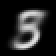

In [7]:
random_number = np.asarray([[np.random.normal() 
                            for _ in range(latent_space_depth)]])
def decode_img(a):
    a = np.clip(a * 256, 0, 255).astype('uint8')
    return PIL.Image.fromarray(a)

decode_img(decoder.predict(random_number).reshape(img_width, img_height)).resize((56, 56))


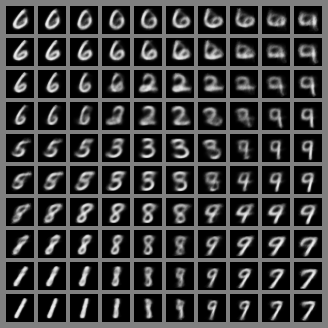

In [8]:
num_cells = 10

overview = PIL.Image.new('RGB', 
                         (num_cells * (img_width + 4) + 8, 
                          num_cells * (img_height + 4) + 8), 
                         (128, 128, 128))

vec = np.zeros((1, latent_space_depth))
for x in range(num_cells):
    vec[:, 0] = (x * 3) / (num_cells - 1) - 1.5
    for y in range(num_cells):
        vec[:, 1] = (y * 3) / (num_cells - 1) - 1.5
        decoded = decoder.predict(vec)
        img = decode_img(decoded.reshape(img_width, img_height))
        overview.paste(img, (x * (img_width + 4) + 6, y * (img_height + 4) + 6))
overview

In [16]:
def ConditionalVariationalAutoEncoder(num_pixels, num_labels):
    pixels = Input(shape=(num_pixels,))
    label = Input(shape=(num_labels,), name='label')

    inputs = concat(name='inputs')([pixels, label])
    
    encoder_hidden = Dense(512, activation='relu', name='encoder_hidden')(inputs)

    z_mean = Dense(latent_space_depth, activation='linear')(encoder_hidden)
    z_log_var = Dense(latent_space_depth, activation='linear')(encoder_hidden)
    
    def KL_loss(y_true, y_pred):
        return(0.5 * K.sum(K.exp(z_log_var) + K.square(z_mean) - 1 - z_log_var, axis=1))

    def reconstruction_loss(y_true, y_pred):
        return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)    

    def total_loss(y_true, y_pred):
        return KL_loss(y_true, y_pred) + reconstruction_loss(y_true, y_pred)

    z = Lambda(sample_z, output_shape=(latent_space_depth, ))([z_mean, z_log_var])
    zc = concat()([z, label])
    
    decoder_hidden = Dense(512, activation='relu')

    reconstruct_pixels = Dense(num_pixels, activation='sigmoid')

    decoder_in = Input(shape=(latent_space_depth + num_labels,))
    hidden = decoder_hidden(decoder_in)
    decoder_out = reconstruct_pixels(hidden)
    decoder = Model(decoder_in, decoder_out)    
    
    hidden = decoder_hidden(zc)
    outputs = reconstruct_pixels(hidden)
    auto_encoder = Model([pixels, label], outputs)

    auto_encoder.compile(optimizer=Adam(lr=0.001), 
                         loss=total_loss,
                         metrics=[KL_loss, reconstruction_loss])
    
    return auto_encoder, decoder

cond_auto_encoder, cond_decoder = ConditionalVariationalAutoEncoder(x_train.shape[1], y_train.shape[1])
cond_auto_encoder.summary()

(None, 2)


ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concat axis. Got inputs shapes: [(250, 2), (None, 10)]

In [ ]:
cond_auto_encoder.fit([x_train, y_train], x_train, verbose=1, 
                      batch_size=batch_size, epochs=50,
                      validation_data = ([x_test, y_test], x_test))

In [ ]:
number_4 = np.zeros((1, latent_space_depth + y_train.shape[1]))
number_4[:, 4 + latent_space_depth] = 1
decode_img(cond_decoder.predict(number_4).reshape(
               img_width, img_height)).resize((56, 56))

In [ ]:
number_8_3 = np.zeros((1, latent_space_depth + y_train.shape[1]))
number_8_3[:, 8 + latent_space_depth] = 0.5
number_8_3[:, 3 + latent_space_depth] = 0.5
decode_img(cond_decoder.predict(number_8_3).reshape(
               img_width, img_height)).resize((56, 56))

In [ ]:
digits = [3, 0, 8, 9]
num_cells = 10

overview = PIL.Image.new('RGB', 
                         (num_cells * (img_width + 4) + 8, 
                          num_cells * (img_height + 4) + 8), 
                         (128, 128, 128))

vec = np.zeros((1, latent_space_depth + y_train.shape[1]))
for x in range(num_cells):
    x1 = [x / (num_cells - 1), 1 - x / (num_cells - 1)]
    for y in range(num_cells):
        y1 = [y / (num_cells - 1), 1 - y / (num_cells - 1)]
        for idx, dig in enumerate(digits):
            vec[:, dig + latent_space_depth] = x1[idx % 2] * y1[idx // 2]
        decoded = cond_decoder.predict(vec)
        img = decode_img(decoded.reshape(img_width, img_height))
        overview.paste(img, (x * (img_width + 4) + 6, y * (img_height + 4) + 6))
overview

In [ ]:
num_cells = 10

overview = PIL.Image.new('RGB', 
                         (num_cells * (img_width + 4) + 8, 
                          num_cells * (img_height + 4) + 8), 
                         (128, 128, 128))

img_it = 0
vec = np.zeros((1, latent_space_depth + y_train.shape[1]))
for x in range(num_cells):
    vec = np.zeros((1, latent_space_depth + y_train.shape[1]))
    vec[:, x + latent_space_depth] = 1
    for y in range(num_cells):
        vec[:, 1] = 3 * y / (num_cells - 1) - 1.5
        decoded = cond_decoder.predict(vec)
        img = decode_img(decoded.reshape(img_width, img_height))
        overview.paste(img, (x * (img_width + 4) + 6, y * (img_height + 4) + 6))
overview